## Hypothesis testing
An assessment of how reasonable the observed data are, assuming a hypothesis is true. The hypothesis you are testing is called the null hypothesis.

### Permutation
Random re-ordering of entries in an array

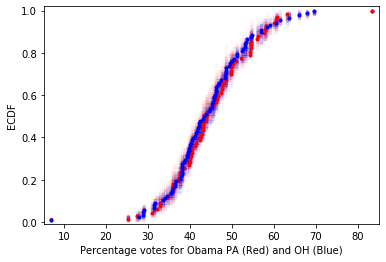

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# get matplot to show charts inline
%matplotlib inline

np.random.seed(42)

df = pd.read_csv('2008_swing_states.csv')
dem_share_PA = df[df['state'] == 'PA']['dem_share'].values
dem_share_OH = df[df['state'] == 'OH']['dem_share'].values
#dem_share_both = np.concatenate((dem_share_PA, dem_share_OH))
#dem_share_both = np.concatenate((np.array([1, 2, 3]), np.array([4, 5, 6])))
#dem_share_perm = np.random.permutation(dem_share_both)
#perm_sample_PA = dem_share_perm[:len(dem_share_PA)]
#perm_sample_OH = dem_share_perm[len(dem_share_PA):]

%run permutation_sample.ipynb
%run ECDF.ipynb

for _ in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(dem_share_PA, dem_share_OH)

    # Compute ECDFs
    x_1, y_1 = compute_ecdf(perm_sample_1)
    x_2, y_2 = compute_ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = compute_ecdf(dem_share_PA)
x_2, y_2 = compute_ecdf(dem_share_OH)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

# Label axes, set margin, and show plot
_ = plt.margins(0.02)
_ = plt.xlabel('Percentage votes for Obama PA (Red) and OH (Blue)')
_ = plt.ylabel('ECDF')
plt.show()

## Test statistic
* A single number that can be computed from observed data, and from data you simulate under the null hypothesis
* It serves as a basis for comparison between what the hypothesis predicts and what we actually observe
* The test statistic needs to be something that is pertinent to the question you are trying to answer with your hypothesis testing, e.g. are PA and OH different

## P-value
* A measure of the probability of obtaining a value of your test statistic that is at least as extreme as was observed, under the assumption that the null hypothesis is true
* It is *NOT* the probability that the null hypothesis is true
* If the p-value is small it is said that the data are statistically significantly different than what we will observe under the null hypothesis

In [2]:
reader = pd.read_csv('frog_tongue.csv', comment='#', usecols=('ID', 'impact force (mN)'), chunksize=100)
# read only frog II and III's data
df = pd.concat(chunck[(chunck['ID'] == 'II') | (chunck['ID'] == 'III')] for chunck in reader)
df.rename(columns={'impact force (mN)':'force'}, inplace=True)
df['force'] = df['force'] / 1_000
df.head()

ID  force
20  II  1.612
21  II  0.605
22  II  0.327
23  II  0.946
24  II  0.541

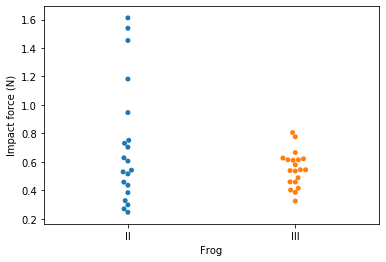

In [3]:
import seaborn as sns

# Make bee swarm plot
_ = sns.swarmplot(x='ID', y='force', data=df)

# Label axes
_ = plt.xlabel('Frog')
_ = plt.ylabel('Impact force (N)')

# Show the plot
plt.show()

In [4]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2
    #print(np.mean(data_1))
    #print(np.mean(data_2))
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [5]:
force_a = df[df['ID'] == 'II']['force']
force_b = df[df['ID'] != 'II']['force']

# Compute difference of mean impact force from experiment
empirical_diff_means = diff_of_means(force_a, force_b)
print('empirical_diff_means:', empirical_diff_means)

%run draw_perm_reps.ipynb

# Draw 10,000 permutation replicates
perm_replicates = draw_perm_reps(force_a, force_b, diff_of_means, size=10_000)

# Compute p-value
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

empirical_diff_means: 0.15725000000000022
p-value = 0.0621


## Pipeline for hypothesis testing
1.  Clearly state the null hypothesis
2.  Define your test statistic
3.  Generate many sets of simulated data assuming the null hypothesis is true
4.  Compute the test statistic for each simulated data set
5.  The p-value is the fraction of your simulated data sets for which the test statistic is at least as extreme as for the real data

### A one-sample bootstrap hypothesis test

In [6]:
reader = pd.read_csv('frog_tongue.csv', comment='#', usecols=('ID', 'impact force (mN)'), chunksize=100)
# read only frog IV's data
df = pd.concat(chunck[chunck['ID'] == 'IV'] for chunck in reader)
df.rename(columns={'impact force (mN)':'force'}, inplace=True)
df['force'] = df['force'] / 1_000

diff_in_mean = np.mean(force_b) - np.mean(df['force'])

# Make an array of translated impact forces for frog IV
translated_force_iv = df['force'] + diff_in_mean

%run draw_bs_reps.ipynb

# Take bootstrap replicates of Frog IV's translated impact forces
bs_replicates = draw_bs_reps(translated_force_iv, np.mean, 10_000)

# Compute fraction of replicates that are less than the observed Frog IV force
p = np.sum(bs_replicates <= np.mean(df['force'])) / 10_000

# Print the p-value
print('p = ', p)

p =  0.0052


### A two-sample bootstrap hypothesis test for difference of means

In [7]:
# Compute mean of all forces
mean_force = np.mean(df['force'].append(force_a, ignore_index=True))

# Generate shifted arrays
force_ii_shifted = force_a - np.mean(force_a) + mean_force
force_iv_shifted = df['force'] - np.mean(df['force']) + mean_force

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_ii_shifted, np.mean, 10_000)
bs_replicates_b = draw_bs_reps(force_iv_shifted, np.mean, 10_000)

# Get replicates of difference of means
bs_replicates = bs_replicates_b - bs_replicates_a

# Compute and print p-value
empirical_diff_means = np.mean(df['force']) - np.mean(force_a) 
p = np.sum(bs_replicates <= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)

p-value = 0.0058


## A/B test
* To see if a strategy change gives a better result
* A low p-value might indicate an improvement in performance

### The vote for the Civil Rights Act in 1964
The Civil Rights Act of 1964 was one of the most important pieces of legislation ever passed in the USA. Excluding "present" and "abstain" votes, 153 House Democrats and 136 Republicans voted yea. However, 91 Democrats and 35 Republicans voted nay. Did party affiliation make a difference in the vote?

To answer this question, you will evaluate the hypothesis that the party of a House member has no bearing on his or her vote. You will use the fraction of Democrats voting in favor as your test statistic and evaluate the probability of observing a fraction of Democrats voting in favor at least as small as the observed fraction of 153/244. (That's right, at least as small as. In 1964, it was the Democrats who were less progressive on civil rights issues.) To do this, permute the party labels of the House voters and then arbitrarily divide them into "Democrats" and "Republicans" and compute the fraction of Democrats voting yea.

In [8]:
# Construct arrays of data: dems, reps
dems = np.array([True] * 153 + [False] * 91)
reps = np.array([True] * 136 + [False] * 35)

def frac_yea_dems(dems, reps):
    """Compute fraction of Democrat yea votes."""
    frac = sum(dems) / len(dems)
    return frac

# Acquire permutation samples
perm_replicates = draw_perm_reps(dems, reps, frac_yea_dems, 10_000)

# Compute and print p-value
p = np.sum(perm_replicates <= 153/244) / len(perm_replicates)
print('p-value =', p)

p-value = 0.0001


### Hypothesis test on Pearson correlation
The observed correlation between female illiteracy and fertility may just be by chance; the fertility of a given country may actually be totally independent of its illiteracy. You will test this hypothesis. To do so, permute the illiteracy values but leave the fertility values fixed. This simulates the hypothesis that they are totally independent of each other. For each permutation, compute the Pearson correlation coefficient and assess how many of your permutation replicates have a Pearson correlation coefficient greater than the observed one.

In [9]:
df = pd.read_csv('female_literacy_fertility.csv')
# Always strip (hidden) spaces from column names
df.columns = df.columns.str.strip()
df['illiteracy'] = 100 - df['female literacy']
df.head()

Country Continent  female literacy  fertility     population  illiteracy
0      Chine       ASI             90.5      1.769  1,324,655,000         9.5
1       Inde       ASI             50.8      2.682  1,139,964,932        49.2
2        USA       NAM             99.0      2.077    304,060,000         1.0
3  Indonésie       ASI             88.8      2.132    227,345,082        11.2
4     Brésil       LAT             90.2      1.827    191,971,506         9.8

In [11]:
%run pearson_r.ipynb

# Compute observed correlation
r_obs = pearson_r(df['illiteracy'], df['fertility'])

# Initialize permutation replicates
perm_replicates = np.empty(10_000)

# Draw replicates
for i in range(10_000):
    # Permute illiteracy measurments: illiteracy_permuted
    illiteracy_permuted = np.random.permutation(df['illiteracy'])

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(illiteracy_permuted, df['fertility'])

# Compute p-value: p
p = np.sum(perm_replicates > r_obs) / 10_000
print('p-val =', p)

p-val = 0.0
